In [ ]:
!pip install gcsfs

In [2]:
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib as mpl
import matplotlib.style
mpl.style.use('seaborn-bright')
%matplotlib inline

In [46]:
fs = gcsfs.GCSFileSystem(project='omina-gcp-resource')
with fs.open('omina-test-set/occupancy-data/occupancy_data.csv') as f:
    df = pd.read_csv(f)

In [47]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['Unnamed: 0']

In [48]:
df = df.sort_values(by='date')

In [49]:
df_group = df.groupby(pd.Grouper(key = 'date', freq = 'D'))
df['NSM'] = df.date.apply(lambda x: x - x.replace(hour=0, minute=0, second=0)).dt.total_seconds()
df['WS'] = ((pd.DatetimeIndex(df.index).dayofweek) < 5).astype(int)
del df['date']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
date,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,51540.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,51599.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,51660.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,51720.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,51780.0,1


In [50]:
df_dependant = df[['Temperature', 'Light', 'CO2']]
df_X = StandardScaler().fit_transform(df_dependant)

In [51]:
df_pca = PCA(n_components=2)
principalComponents = df_pca.fit_transform(df_X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'], index = df.index)
print(df_pca.explained_variance_ratio_)
principalDf.head()

[0.68888537 0.20730648]


,PC1,PC2
date,,
2015-02-02 14:19:00,3.017202,-1.575648
2015-02-02 14:19:59,3.026356,-1.539075
2015-02-02 14:21:00,3.031954,-1.507646
2015-02-02 14:22:00,2.808232,-1.354420
2015-02-02 14:23:00,2.818499,-1.344489


In [52]:
df['PC1'] = principalDf['PC1']
df['PC2'] = principalDf['PC2']
del df['Temperature']
del df['Light']
del df['CO2']
df.head()

,Humidity,HumidityRatio,Occupancy,NSM,WS,PC1,PC2
date,,,,,,,
2015-02-02 14:19:00,26.272,0.004764,1,51540.0,1,3.017202,-1.575648
2015-02-02 14:19:59,26.290,0.004773,1,51599.0,1,3.026356,-1.539075
2015-02-02 14:21:00,26.230,0.004765,1,51660.0,1,3.031954,-1.507646
2015-02-02 14:22:00,26.125,0.004744,1,51720.0,1,2.808232,-1.354420
2015-02-02 14:23:00,26.200,0.004767,1,51780.0,1,2.818499,-1.344489


In [53]:
df_train = df['2015-02-02 14:19:00' : '2015-02-14 23:59:59']
df_test = df['2015-02-15 00:00:00' : '2015-02-18 09:19:00']
df_test.shape, df_train.shape, df.shape

((4880, 7), (15680, 7), (20560, 7))

In [54]:
feature_names = ['PC1', 'Humidity', 'PC2', 'HumidityRatio', 'NSM', 'WS']
df_X_train = df_train[feature_names]
df_y_train = df_train['Occupancy']
df_X_test = df_test[feature_names]
df_y_test = df_test['Occupancy']

In [55]:
X_train = df_X_train.as_matrix()
y_train = df_y_train.as_matrix()
X_test = df_X_test.as_matrix()
y_test = df_y_test.as_matrix()

In [56]:
CV_score = np.empty((0, 4))
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
  y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
  models = (LogisticRegression(), GaussianNB(),  SVC(),   RandomForestClassifier(n_estimators = 100))
  models = (clf.fit(X_train_cv, y_train_cv) for clf in models)
  CV_score = np.append(CV_score, [list(clf.score(X_test_cv, y_test_cv) for clf in models)], axis = 0)

In [57]:
CV_score

array([[0.92843475, 0.82242633, 0.82969767, 0.95216227],
       [0.93226177, 0.93991581, 0.85036357, 0.85151167],
       [0.96938385, 0.9598163 , 0.7956372 , 0.97244546],
       [0.83352468, 0.88251052, 0.87523919, 0.87523919],
       [0.92384233, 0.97359357, 0.91197857, 0.9800995 ]])

In [58]:
CV_score_mean = np.mean(CV_score, axis = 0)
CV_score_std = np.std(CV_score, axis = 0)

In [59]:
CV_score_mean

array([0.91748948, 0.91565251, 0.85258324, 0.92629162])

In [60]:
titles = ('LR',
          'GNB',
          'SVM',
          'RF')
df_CV = pd.DataFrame({'Mean':CV_score_mean, 'Std. Dev':CV_score_std}, index =titles)
df_CV.head()

,Mean,Std. Dev
LR,0.917489,0.044992
GNB,0.915653,0.056010
SVM,0.852583,0.039529
RF,0.926292,0.052713


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://data_box.svg [Content-Type=image/svg+xml]...
/ [1 files][ 29.0 KiB/ 29.0 KiB]                                                
Operation completed over 1 objects/29.0 KiB.                                     


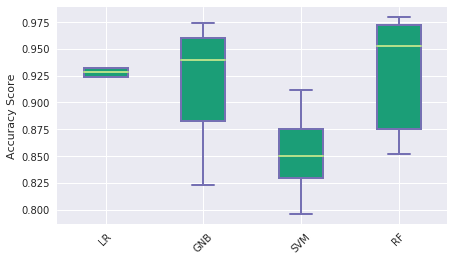

In [61]:

# Create a figure instance
fig = plt.figure(1, figsize=(7, 4))

# Create an axes instance
ax = fig.add_subplot(111)## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(CV_score, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

ax.set_xticklabels(titles, rotation = 45)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Accuracy Score')
plt.savefig("data_box.svg", format="svg")
!gsutil cp 'data_box.svg' 'gs://omina-test-set/occupancy-data/data_box.svg'

In [62]:
tscv = TimeSeriesSplit(n_splits=5)
# build a classifier
clf = RandomForestClassifier(n_estimators=500)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# use a full grid over all parameters
param_grid = {'n_estimators': [10, 50, 100, 200], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, None], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=tscv)
grid_search.fit(X_train, y_train)

report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.941 (std: 0.045)
Parameters: {'min_samples_leaf': 8, 'n_estimators': 10, 'min_samples_split': 5, 'criterion': 'gini', 'max_features': 'auto', 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.940 (std: 0.044)
Parameters: {'min_samples_leaf': 8, 'n_estimators': 50, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.939 (std: 0.049)
Parameters: {'min_samples_leaf': 8, 'n_estimators': 100, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': None}



In [115]:
rf = RandomForestClassifier(min_samples_leaf = 8, n_estimators = 10, min_samples_split = 5, criterion = 'gini', max_features = 'auto', max_depth = 10)
rf.fit(X_train, y_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.99
Accuracy of Random Forest classifier on test set: 0.95


In [116]:
class_names = np.array(['0', '1'])

In [117]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_mat)

    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) # , rotation = 45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, format(conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3543  240]
 [   0 1097]]
Copying file://data_conf_mat.svg [Content-Type=image/svg+xml]...
/ [1 files][ 33.4 KiB/ 33.4 KiB]                                                
Operation completed over 1 objects/33.4 KiB.                                     
Normalized confusion matrix
[[0.94 0.06]
 [0.   1.  ]]


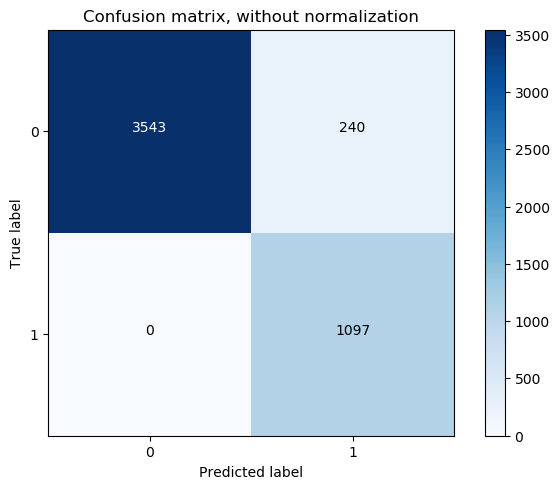

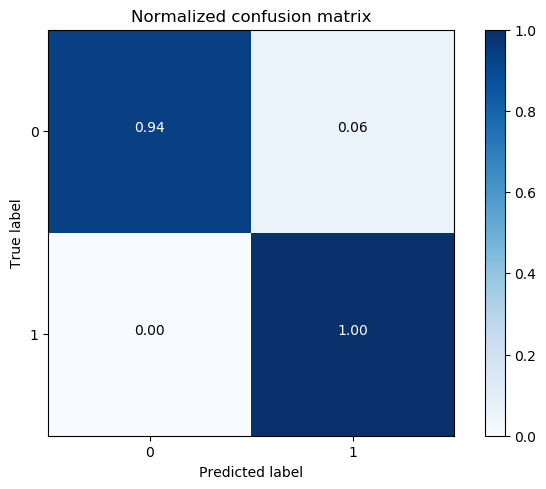

In [118]:
pred = rf.predict(X_test)
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig("data_conf_mat.svg", format="svg")
!gsutil cp 'data_conf_mat.svg' 'gs://omina-test-set/occupancy-data/data_conf_mat.svg'

# Plot normalized confusion matrix

plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



In [119]:
final_acc = classification_report(y_test, pred)
print(final_acc)

             precision    recall  f1-score   support

          0       1.00      0.94      0.97      3783
          1       0.82      1.00      0.90      1097

avg / total       0.96      0.95      0.95      4880



In [120]:
plt.rcParams.update(plt.rcParamsDefault)